### Implement Sigmoid

Following implements $sigmoid(x)\:=\: \frac{1}{1 + e^{-x}}$

First create a Graph, which is the recipe for the sequence of operations to perform

In [1]:
import tensorflow as tf
import numpy as np

#Can create a Graph as follows
#graph = tf.Graph()
#or
#graph = tf.get_default_graph()

Create tensors
- x: Placeholder, the variables that we will give at runtime
- W and b: mutable tensors, they change with time, say in each iteration, variables need an initializer
- h: imutable tensor, produces as a result of some operations on other tensors


In [2]:
x = tf.placeholder(shape = [None, 10], name = 'x', dtype = tf.float32)
W = tf.Variable(tf.random_uniform(shape = [10, 5], dtype = tf.float32, minval = -0.1, maxval = 0.1), name = 'W')
b = tf.Variable(tf.zeros(shape = [5], dtype = tf.float32), name = 'b')
h = tf.nn.sigmoid(tf.matmul(x, W) + b)
print('shape of h is', h.shape)
init = tf.global_variables_initializer()
np.random.seed(1234)
with tf.Session() as session:
    session.run(init)
    h_eval = session.run(h, feed_dict = {x: np.random.rand(1, 10)})

print('h_eval is', h_eval)

shape of h is (?, 5)
h_eval is [[ 0.52049112  0.49635988  0.48334688  0.49741691  0.48985034]]



Placeholders can also be replaced by preloaded constants where the values do not depend on runtime as follows, note that we dont need ``feed_dict`` in this case as the input is constant


In [3]:
c = tf.constant(value = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]], dtype= tf.float32)
W_c = tf.Variable(tf.random_uniform(shape = [10, 5], dtype = tf.float32, minval = -0.1, maxval = 0.1), name = 'W')
b_c = tf.Variable(tf.zeros(shape = [5], dtype = tf.float32), name = 'b')
h_c = tf.nn.sigmoid(tf.matmul(c, W) + b)
print('shape if h is', h_c.shape)
with tf.Session() as session:
    tf.global_variables_initializer().run()
    h_eval = session.run(h_c)

print('h_eval is', h_eval)

shape if h is (1, 5)
h_eval is [[ 0.15896994  0.47830001  0.7322498   0.34032491  0.73249787]]


### Building pipeline

We will now source the data from 3 text files files each containing 5 lines with each line being 10 comma seperated float values. First, we will create the files if they don't already exist with sample data and then build a pipeline to read the data from files all the way to loading them into tensors.

In [4]:
def create_sample_if_not_exist(filename, numrows = 5, numcols = 10, seed = None):
    import numpy as np
    import os
    if os.path.exists(filename):
        print('File', filename, 'exists, not creating one')
    else:
        print('Creating', filename)
        if seed is not None:
            np.random.seed(seed)
    
        with open(filename, 'w') as f:
            for _ in range(numrows):
                f.write(",".join(np.random.rand(numcols).astype(str).tolist()) + "\n")

In [5]:
filenames = ['text%d.txt'%i for i in range(1, 4)]
for filename in filenames:
    create_sample_if_not_exist(filename)

File text1.txt exists, not creating one
File text2.txt exists, not creating one
File text3.txt exists, not creating one


We will create a string input producer that will peduce tensors holding the string values held in filenames. We shuffle the input and bound the queue to size 3.  

In [6]:
filename_queue = tf.train.string_input_producer(filenames, capacity = 3, shuffle = True, name = 'str_inp_prod')

Once the queue is created, we will initialize a ``TextLineReader`` which will read a line from the text. The read operation returns the values as a key and a value. The key is the name of the file and the value is one line from this file

In [7]:
reader = tf.TextLineReader()
key, value = reader.read(filename_queue, name = 'text_line_op')

Decode csv to read 10 values (which we expect in our csv file). These would be 10 independent tensors, we want these 10 values to become our feature vector

In [8]:
#Incase of bad line
default_record = [[-1.0]] * 10

col1, col2, col3, col4, col5, col6, col7, col8, col9, col10 = tf.decode_csv(value, record_defaults = default_record)
feature = tf.stack([col1, col2, col3, col4, col5, col6, col7, col8, col9, col10])


The variable ``features`` above represents one tensor of size (10, ), representing a single training sample from the input files. We need to read multiple records in batches. Following line allows us to read multiple tensors as a batch. The parameters ``batch_size`` is the mini batch size, capacity is the capacity of the queue containing items, the value ``min_after_dequeue`` represents the number of values to retain in the queue after the dequee operation of the elements in batch. The ``num_threads`` decides how many threads will generate data in parallel.

The below setup allows tensor flow read batches of data abstracting the source of real data. The source data will be accessed slowly and can be parallelized to retrieve data asynchronously to the whole training process. The tensor below is our input to the training process

In [9]:
x = tf.train.shuffle_batch([feature], batch_size = 3, capacity = 5, min_after_dequeue = 1, num_threads = 2)
print('shape of x is expected to be (<batch_size>, <feature_dimension>) and is', x.shape)

shape of x is expected to be (<batch_size>, <feature_dimension>) and is (3, 10)


In [10]:
#Define the sigmoid operation again

W = tf.Variable(tf.random_uniform(shape = (10, 5), minval = -0.1, maxval = 0.1, dtype = tf.float32), name = 'W')
b = tf.Variable(tf.zeros(shape = (5, )), dtype = tf.float32, name = 'b')
h = tf.nn.sigmoid(tf.matmul(x, W) + b)
with tf.Session() as session:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord = coord, sess = session)
    tf.global_variables_initializer().run()
    
    for step in range(5):
        x_eval, h_eval = session.run([x, h])
        print('================ Step %d ================'%step)
        print('Evaluated data (x)')
        print(x_eval)
        print('Evaluated data (h)')
        print(h_eval)
    
    #Request all threads to stop processing
    coord.request_stop()
    #Wait for all threads to gracefully stop, not needed in a notebook environment
    coord.join(threads)

================ Step 0 ================
Evaluated data (x)
[[ 0.72665846  0.90008783  0.77916378  0.59915477  0.29112524  0.15139526
   0.33517465  0.65755177  0.07334255  0.0550064 ]
 [ 0.32570741  0.19361869  0.45781165  0.92040259  0.87906915  0.25261575
   0.34800878  0.18258873  0.90179604  0.70652819]
 [ 0.00934857  0.90064859  0.97724146  0.55689466  0.08477385  0.33300248
   0.72842866  0.14243537  0.55246896  0.27304325]]
Evaluated data (h)
[[ 0.49464947  0.52583575  0.50423062  0.49881858  0.50255448]
 [ 0.45626062  0.53781515  0.50380903  0.49873108  0.51279169]
 [ 0.48437965  0.51267284  0.50956738  0.50125998  0.52063322]]
================ Step 1 ================
Evaluated data (x)
[[ 0.73852307  0.58730364  0.47163254  0.10712682  0.22921857  0.89996517
   0.41675353  0.53585166  0.00620852  0.30064172]
 [ 0.97449511  0.6677869   0.25565329  0.1083115   0.77618074  0.78247797
   0.76160389  0.91440314  0.6586228   0.5683676 ]
 [ 0.28525096  0.62491673  0.4780938   0.1956

#### Defining Variables in tensorflow

Following code snippet shows difference between ``tf.Variable`` and ``tf.constant``. variable can be assigned new value but a constant cannot be

In [22]:
variable = tf.Variable(0, dtype = tf.int32)
constant = tf.constant(0, dtype = tf.int32)
variable = tf.assign(variable, variable + 10)
try:
    tf.assign(constant, constant + 10)
except Exception as e:
    print('Caught Exception, ', e)
    
with tf.Session() as session:
    tf.global_variables_initializer().run()
    print('[variable, constant] is', session.run([variable, constant]))

Caught Exception,  'Tensor' object has no attribute 'assign'
[variable, constant] is [10, 0]


Casting the variable type is as follows

In [25]:
variable_float32 = tf.cast(variable, dtype = tf.float32)
print('variable.dtype is', variable.dtype, ', variable_float32.dtype is', variable_float32.dtype)


variable.dtype is <dtype: 'int32_ref'> , variable_float32.dtype is <dtype: 'float32'>


Initializers for variables work as follows (note the difference in constant_initialized). 

In [58]:
tf.reset_default_graph()
constant_initialized = tf.get_variable(initializer = tf.constant_initializer(2),  shape = [2, 2], 
                                   name = 'const_init', 
                                   dtype = tf.float32)

zero_initialized = tf.Variable(tf.zeros(shape = [3, 3], dtype = tf.float32), name = 'zeros')
random_initialized = tf.Variable(tf.random_uniform(shape = [3, 3], dtype = tf.float32), name = 'rand_init')
#Truncated normal drops all values 2 std away from mean and re-picks them
truncated_norm_initialized = tf.Variable(tf.truncated_normal(shape =[3, 3], dtype = tf.float32), name = 'tn')
large_truncated_norm_initialized = tf.Variable(tf.truncated_normal(shape =[5000, 5000], dtype = tf.float32), 
                                               name = 'large_tn')

with tf.Session() as session:
    tf.global_variables_initializer().run()
    print('constant_initialized', session.run(constant_initialized))
    print('zero_initialized', session.run(zero_initialized))
    print('truncated_norm_initialized', session.run(truncated_norm_initialized))
    print('mean of truncated_normal is', session.run(tf.reduce_mean(large_truncated_norm_initialized)))


constant_initialized [[ 2.  2.]
 [ 2.  2.]]
zero_initialized [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
truncated_norm_initialized [[ 0.13495584  0.04675447 -1.77191257]
 [ 1.35239267 -1.58421326 -0.45300278]
 [ 0.43457615 -1.06277609 -0.2075759 ]]
mean of truncated_normal is 0.000168789


#### Comparison operations in Tensorflow

In [66]:
x = tf.constant([[1, 2], [3, 4]], dtype = tf.int32)
y = tf.constant([[4, 3], [3, 2]], dtype = tf.int32)

#Element wise equality, x == y
is_equal = tf.equal(x, y)

#Element wise less than x < y (similarly we have greater)
is_less = tf.less(x, y)

#Element wise greater than or equal to (similarly we have less_equal)
greater_or_equal = tf.greater_equal(x, y)

#Conditional select, takes the form (mask, x, y). If element of mask is true, take from x else y

max_valued = tf.where(greater_or_equal, x, y)

with tf.Session() as session:
    tf.global_variables_initializer().run()
    print('is_equal', session.run(is_equal))
    print('is_less', session.run(is_less))
    print('greater_or_equal', session.run(greater_or_equal))
    print('max_valued', session.run(max_valued))

is_equal [[False False]
 [ True False]]
is_less [[ True  True]
 [False False]]
greater_or_equal [[False False]
 [ True  True]]
max_valued [[4 3]
 [3 4]]


#### Following are some mathematical operations

In [85]:
#Element wise addition
x_add_y = tf.add(x, y)

#matrix multiplication
x_mul_y = tf.matmul(x, y)

#Take natural log, log operation requires type to be float16, float32, float64, complex64, complex128
log_x = tf.log(tf.cast(x, tf.float32))

#sum all elements to give a scalar
all_sum = tf.reduce_sum(x)

#Sum across a specific dimension
sum_all_rows = tf.reduce_sum(x, axis = 0)

sum_all_cols = tf.reduce_sum(x, axis = 1)

#Sum across a specific dimension retaining the dimensionality
sum_rows_retain_dims = tf.reduce_sum(x, axis = 0, keep_dims = True)

sum_cols_retain_dims = tf.reduce_sum(x, axis = 1, keep_dims = True)

#sum, grouped by segments, segments expected to have same length as the range to sum on
range_const = tf.constant(np.arange(1, 11), dtype = tf.int32, name = 'range')
segments = tf.constant([0, 0, 0, 1, 1, 2, 2, 2, 2, 2], dtype = tf.int32, name = 'segments')
seg_sum = tf.segment_sum(range_const, segments)

with tf.Session() as session:
    tf.global_variables_initializer().run()
    print('x_add_y', session.run(x_add_y))
    print('x_mul_y', session.run(x_mul_y))
    print('log_x', session.run(log_x))
    print('all_sum', session.run(all_sum))
    print('sum_all_rows', session.run(sum_all_rows), ', shape is', sum_all_rows.shape)
    print('sum_all_cols', session.run(sum_all_cols), ', shape is', sum_all_cols.shape)
    print('sum_rows_retain_dims', session.run(sum_rows_retain_dims), ', shape is', sum_rows_retain_dims.shape)
    print('sum_cols_retain_dims', session.run(sum_cols_retain_dims), ', shape is', sum_cols_retain_dims.shape)
    print('seg_sum', session.run(seg_sum))
    
    
    

x_add_y [[5 5]
 [6 6]]
x_mul_y [[10  7]
 [24 17]]
log_x [[ 0.          0.69314718]
 [ 1.09861231  1.38629436]]
all_sum 10
sum_all_rows [4 6] , shape is (2,)
sum_all_cols [3 7] , shape is (2,)
sum_rows_retain_dims [[4 6]] , shape is (1, 2)
sum_cols_retain_dims [[3]
 [7]] , shape is (2, 1)
seg_sum [ 6  9 40]



#### Scatter Gather operations

We cannot slice a tensor as we would slice a numpy array as ``a[10, 12]`` or ``a[:, 1:3]`` etc. Similarly we cannot selectively set the values of a tensor using the index. Scatter gather operations let us set and get values at specified indices respectively of the tensor.

In [104]:
#1D scatter operation
#The variable to be updated
ref = tf.Variable(np.arange(10), dtype = tf.float32, name = 'ref')

#Index position to update
idx = tf.constant([3, 4, 5], dtype = tf.int32, name = 'idx')
update_val = tf.constant([99, 99, 99], dtype = tf.float32, name = 'updated_value')
updated = tf.scatter_update(ref, idx, update_val)

#Scatter multidimensional.
# Initialized to 0 (for both int and float) for numeric values and empty for string
index = [[1], [3]] #Row number
values = [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]
scatter_nd_1 = tf.scatter_nd(index, values, shape = [4, 3])

#Anothet example by using both dimensions
index = [[1, 3], [2, 2]] #Row and column
values = [1, 2]
scatter_nd_2 = tf.scatter_nd(index, values, shape = [3, 4])

with tf.Session() as session:
    tf.global_variables_initializer().run()
    print('input 1D tensor is', session.run(ref))
    print('updated 1D tensor is', session.run(updated))
    print('scatter_nd_1,', session.run(scatter_nd_1), ', dtype,', scatter_nd_1.dtype)
    print('scatter_nd_2,', session.run(scatter_nd_2), ', dtype,', scatter_nd_2.dtype)
    


input 1D tensor is [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
updated 1D tensor is [  0.   1.   2.  99.  99.  99.   6.   7.   8.   9.]
scatter_nd_1, [[ 0.  0.  0.]
 [ 1.  2.  3.]
 [ 0.  0.  0.]
 [ 4.  5.  6.]] , dtype, <dtype: 'float32'>
scatter_nd_2, [[0 0 0 0]
 [0 0 0 1]
 [0 0 2 0]] , dtype, <dtype: 'int32'>


Similarly, following are the gather operations

In [108]:

# 1 D slice
values = tf.constant(np.arange(10), name = '1d')
index = [1, 6]
slice1d = tf.gather(values, index)

#ND slice
values = tf.constant([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
index = [[1], [3]]  #Rows
slice2d = tf.gather_nd(values, index)

#ND Slice, [row, col]
index = [[1, 2], [3, 1]]  #[Row, col]
slice2d_2 = tf.gather_nd(values, index)

with tf.Session() as session:
    tf.global_variables_initializer().run()
    print('slice1d,', session.run(slice1d))
    print('slice2d,', session.run(slice2d))
    print('slice2d_2,', session.run(slice2d_2))

slice1d, [1 6]
slice2d, [[ 4  5  6]
 [10 11 12]]
slice2d_2, [ 6 11]


#### Convolution operation.

We will use the following image taken from [this][1] wiki page

![Image](input_image.png)

and apply convolution operation, specifically we will use the kernel

$
\begin{bmatrix}
-1 & -1 &-1\\
-1 & 8 &-1\\
-1 & -1 &-1\\
\end{bmatrix}
$

for edge detection

[1]:https://en.wikipedia.org/wiki/Kernel_(image_processing)

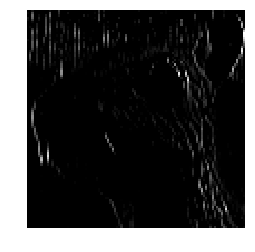

In [163]:
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
image = np.array(Image.open('input_image.png'))

#4D [batch_size, height, width, channels]
image_tensor = tf.constant(image.reshape(1, *image.shape), dtype = tf.float32)

arr = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
kernel = np.array([arr, arr, arr]).reshape(3, 3, 3, 1)

#4D [height, width, input_channels, output_channels]
kernel_tensor = tf.constant(kernel, tf.float32)

#strides = [batch_stride, height_stride, width_stride, channels_stride]
#padding, 'SAME' for padding, 'VALID' for no padding
conv_op = tf.nn.conv2d(image_tensor, kernel_tensor, strides = [1, 1, 1, 1], padding = 'VALID')

with tf.Session() as session:
    conv_image = session.run(conv_op)[0]
    
conv_shape = conv_image.shape
conv_image = conv_image.reshape((conv_shape[0], conv_shape[1]))
conv_image[conv_image < 0] = 0
plt.axis('Off')
plt.imshow(conv_image, cmap = 'gray')
plt.show()